In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image 

Part one : tensorflow 读取数据的三种方式

In [3]:
#1：从Constent 中读取数据
X = tf.constant([[2,3],[5,6]],dtype=tf.float32,name='X')
Y = tf.constant([4,7],dtype=tf.float32,name='Y')
Z = X+Y
with tf.Session() as sess:
    print(sess.run(Z))

[[ 6. 10.]
 [ 9. 13.]]


In [4]:
#2：feed 方式
X_1 = tf.placeholder(tf.float32,shape=[None,2],name='X_1')
Y_1 = tf.placeholder(tf.float32,name='Y_1')
Z = X+Y
with tf.Session() as sess:
    print(sess.run(Z,feed_dict={X_1:[[2,3],[5,6]],Y_1:[4,7]}))

[[ 6. 10.]
 [ 9. 13.]]


Pipeline: XXXReader, Queue

Queue机制：
1. producer-consumer pattern(生产消费模式)
2. 独立于主线程执行
3. 异步IO: reader.read(queue)  tf.train.batch()

tf.TextLineReader()

tf.WholeFileReader()

tf.TFRecordReader()

![alt text](file_queue.gif "File Queue") 

In [4]:
#3： 通过Queque读取数据
fileList = tf.train.match_filenames_once('./data/*.csv',name='getFileList')
#等同于写fileList = [b'.\\data\\A.csv' b'.\\data\\B.csv' b'.\\data\\C.csv']

#创建fileName Queque
fileNameQueque = tf.train.string_input_producer(fileList,num_epochs=5,capacity=20,name='fileNameQueque')
#string_input_producer
#slice_input_producer具体在同一文件夹下的pdf里讲的很详细
#两个op 入队和出队，通过循环调用deq也能遍历队列
#enq = fileNameQueque.enqueue([b'.\\data\\A.csv', b'.\\data\\B.csv', b'.\\data\\C.csv'])
#deq = fileNameQueque.dequeue()

#创建reader
reader = tf.TextLineReader(name='TextLineReader')
key, value = reader.read(fileNameQueque)
#其中key跟文件名有关，value是文件中每一行的值，print(sess.run([key,value]))形式如下：
"""
[b'.\\data\\B.csv:1', b'B1,b1']
[b'.\\data\\B.csv:2', b'B2,b2']
[b'.\\data\\B.csv:3', b'B3,b3']
[b'.\\data\\A.csv:1', b'A1,a1']
[b'.\\data\\A.csv:2', b'A2,a2']

"""

example,label = tf.decode_csv(value,record_defaults=[['null'],['null']])
#把example、label 集成batch形式
example_batch,label_batch = tf.train.shuffle_batch([example,label],4,40,20)

init_op = tf.local_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op)
    coord = tf.train.Coordinator() #线程管理协调器
    threads = tf.train.start_queue_runners(coord=coord) #启动QueueRunner

    try:
        for i in range(20):
            print(sess.run([example_batch,label_batch]))
    except:
        print('error')
        
    coord.request_stop()
    coord.join(threads)

[array([b'c3', b'C2', b'B3', b'A1'], dtype=object), array([b'c3', b'c2', b'b3', b'a1'], dtype=object)]
[array([b'C2', b'B2', b'A3', b'B1'], dtype=object), array([b'c2', b'b2', b'a3', b'b1'], dtype=object)]
[array([b'A3', b'A2', b'A2', b'B1'], dtype=object), array([b'a3', b'a2', b'a2', b'b1'], dtype=object)]
[array([b'B3', b'C1', b'C2', b'B3'], dtype=object), array([b'b3', b'c1', b'c2', b'b3'], dtype=object)]
[array([b'A1', b'B1', b'A3', b'c3'], dtype=object), array([b'a1', b'b1', b'a3', b'c3'], dtype=object)]
[array([b'B2', b'C1', b'B1', b'A1'], dtype=object), array([b'b2', b'c1', b'b1', b'a1'], dtype=object)]
[array([b'c3', b'A2', b'C1', b'A3'], dtype=object), array([b'c3', b'a2', b'c1', b'a3'], dtype=object)]
[array([b'C1', b'A1', b'A3', b'B3'], dtype=object), array([b'c1', b'a1', b'a3', b'b3'], dtype=object)]
[array([b'c3', b'B2', b'B3', b'c3'], dtype=object), array([b'c3', b'b2', b'b3', b'c3'], dtype=object)]
[array([b'A1', b'B2', b'A2', b'B2'], dtype=object), array([b'a1', b'b2', 

### TensorFlow 数据统一数据输入格式TFRecord

why tfrecord, why not csv, jpg, png etc. ?

<b>1. 统一不同输入文件的框架</b>

<b>2. 节约空间（TFRecord压缩的二进制文件, protocal buffer序列化）</b>

```c++
message Example {
  Features features = 1;
};

message Features {
  map<string, Feature> feature = 1;
};

message Feature {
  oneof kind {
    BytesList bytes_list = 1;
    FloatList float_list = 2;
    Int64List int64_list = 3;
  }
};

```

将原始数据转换为TFRecord存储

In [5]:
#convert csv files to tfrecord
#数据预处理：用pandas把values、label提取出来
train_frame = pd.read_csv('train.csv')
train_label = train_frame.pop('label')
train_values = train_frame.values
print('train_values:{}   train_values:{}'.format(train_values.shape,train_label.shape))

train_values:(42000, 784)   train_values:(42000,)


In [6]:
writer = tf.python_io.TFRecordWriter("csv_train.tfrecords")
writer

In [7]:
for i in range(train_label.shape[0]):
    image_raw = train_values[i].tostring()
    example = tf.train.Example(
        features=tf.train.Features(
            feature={
                "image_raw" : tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_raw])),
                "label"   : tf.train.Feature(int64_list=tf.train.Int64List(value=[train_label[i]]))
            }
        )

    )
    writer.write(example.SerializeToString())
writer.close()

In [29]:
#将图片转换成 tfrecord
#Image.open('./data/1.png')
fileNameList = tf.train.match_filenames_once("./data/*.png")
#fileQueque = tf.train.string_input_producer(fileNameList)

writer = tf.python_io.TFRecordWriter("png_train.tfrecords")


with tf.Session() as sess:
    #局部变量初始化
    sess.run(tf.local_variables_initializer())
    fileNameList = sess.run(fileNameList)
    for name in fileNameList:
        img = mpimg.imread(name.decode())
        img_raw = img.tostring()
        label = name    #.decode()
        
        example = tf.train.Example(
            features=tf.train.Features(
                feature={
                    "img_raw" : tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
                    "label"   : tf.train.Feature(bytes_list=tf.train.BytesList(value=[label]))
                }
            )
        )
        writer.write(example.SerializeToString())
    writer.close()
    #print(sess.run(fileNameList))

从TFRecords文件读取数据

In [5]:
#爬取文件名
fileNameList = tf.train.match_filenames_once("csv_train.tfrecords")
#组建文件队列
filename_queque = tf.train.string_input_producer(fileNameList)

#创建reader
reader = tf.TFRecordReader()
f_name,f_record = reader.read(filename_queque)

f_example = tf.parse_single_example(f_record,
                       features={
                           "image_raw" : tf.FixedLenFeature([],tf.string),
                           "label" : tf.FixedLenFeature([],tf.int64)
                       })
img_raw = tf.decode_raw(f_example["image_raw"],tf.int64)
img_raw.set_shape(784,)
label = f_example["label"]

img_batch,label_batch = tf.train.shuffle_batch([img_raw,label],16,32,16)
with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess,coord=coord)
    for i in range(20):
        img_b,l_batch = sess.run([img_batch,label_batch])

    coord.request_stop()
    coord.join(threads)

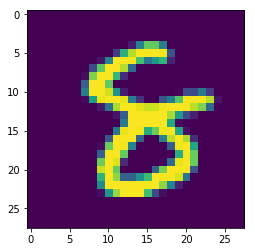

In [11]:
plt.imshow(np.reshape(img_b[0],(28,28))) 
plt.show()

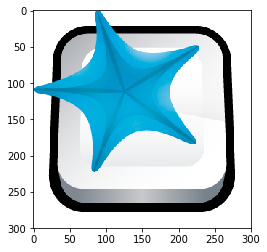

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf

image_raw = tf.gfile.FastGFile("./data/1.png", "rb").read()
img_data = tf.image.decode_png(image_raw)
#img_data = tf.image.decode_jpeg(image_raw)
#img_data = tf.image.convert_image_dtype(img_data, dtype=tf.float32)
encoded_image = tf.image.encode_png(img_data)
    
with tf.Session() as sess:
    plt.imshow(sess.run(img_data))
    plt.show()

    with tf.gfile.GFile("cat_float.jpeg","wb") as f:
        f.write(sess.run(encoded_image))

In [12]:
with tf.Session() as sess:
    img_ = sess.run(img_data)